# Survival Analysis

This is the start of a tutorial on what survival analysis is and how we can use it to help work with HI data which includes both detections and non-detections (aka upper limits).

Heavily based on: David Stark's survival analysis code (https://github.com/dvstark/survival/tree/main, which was used in Stark et al. 2021.

Also uses the lifelines package in python.

This is a work in progress - I had a lot of trouble getting the R packages to play nicely with my installation of python, so this isn't complete yet.


## What is Survival Analysis?

Survival analysis describes statistical techniques which are designed to deal with incomplete data. It was initially developed for statistics of time to patient death in medical settings (e.g. to estimate likely life expectancy following a disease). This technique allows an estimate in instances where some fraction of patients survived (yes it's a slightly gruesome name once you know that).

Most online tutorials use time series data - statistics of when events happen, including times to events which haven't yet happened.

e.g. https://datatab.net/tutorial/survival-analysis

However this technique can be applied to any data set which is a mixture of measurements and upper limits on that measurement - in our case the data we have is HI detections and upper limits (from non-detections).

The [Survival Analysis Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis) article has more details on the history of the technique, and names used in applications in other fields, such as engineering (reliability analysis) or economics (duration analysis).

There's a Python Package [Lifelines](https://lifelines.readthedocs.io/en/latest/Quickstart.html) which does a lot of this (todo: might rewrite to use only Lifelines)


### Basic Example

Let's start with a basic example using some made up data.

**IMPORTANT** You will need the code in `survival.py` from  David Stark's survival analysis code respository (https://github.com/dvstark/survival/tree/main). If you have all the dependencies that needs, you can just put it into the directory you are working in on your own computer (or file system running your code).

I ended up running this in Google Collab, so put it into my Drive system.

In [1]:
##GOOGLE COLLAB SPECIFIC
#This lets the Notebook see Google Drive files. Need only run once.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
#Import statements

#import os
#os.chdir('/Users/dstark/python_packages/my_packages/survival/')
#print(os.getcwd())
#You need the above three lines if you put the survival.py anywhere but in the directory you are running this Notebook from
#And you will need to edit it to tell this notebook where it can find survival.py on your computer
#(or the server you are running this notebook on)


##GOOGLE COLLAB SPECIFIC
#This is to tell the Notebook where survival.py is located. If this popss up an error
#make sure you imported "drive" above
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/SurvivalAnalysis')

#You may also need rpy2 module to be imported.
#Try uncommenting:
#!pip install rpy2

#And/or !pip install fortranformat to run Dave's Survival.py code
!pip install fortranformat



In [ ]:
#Might need to do this one too for lifelines
!pip install lifelines

In [1]:
from survival import setup, ats_fit, kaplan_meier

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal, choice

/opt/anaconda3/envs/rpy2/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/Users/KarenLMasters", R: "/Users/KarenLMasters/Desktop/SurvivalCode"
  warnings.warn(
/opt/anaconda3/envs/rpy2/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/v0/6ck1sx_n1cj3xv334vm2x_mw0000gq/T//RtmpjoRe6X", R: "/var/folders/v0/6ck1sx_n1cj3xv334vm2x_mw0000gq/T//RtmpW7dlZo"
  warnings.warn(


In [4]:
#Run Dave Stark's setup script (sets up R and stuff)
setup()

--- Please select a CRAN mirror for use in this session ---


R callback write-console: trying URL 'https://lib.stat.cmu.edu/R/CRAN/bin/macosx/big-sur-arm64/contrib/4.5/survival_3.8-3.tgz'
  
R callback write-console: Content type 'application/x-gzip'  
R callback write-console:  length 8840059 bytes (8.4 MB)
  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: = 


The downloaded binary packages are in
	/var/folders/v0/6ck1sx_n1cj3xv334vm2x_mw0000gq/T//Rtmp4GVNxV/downloaded_packages


R callback write-console: trying URL 'https://lib.stat.cmu.edu/R/CRAN/bin/macosx/big-sur-arm64/contrib/4.5/NADA_1.6-1.1.tgz'
  
R callback write-console: Content type 'application/x-gzip'  
R callback write-console:  length 490934 bytes (479 KB)
  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R callback write-console: =  
R


The downloaded binary packages are in
	/var/folders/v0/6ck1sx_n1cj3xv334vm2x_mw0000gq/T//Rtmp4GVNxV/downloaded_packages


In [5]:
#let's make some fake data
x = np.random.uniform(size=100) #Make a unfiform random distrobution of 100 x values from 0-1
y = 5 + (3 * x) + np.random.uniform(size=100) #Just a line with error of size 0-1

# set ~30% to be upper limits in y
lims = np.zeros(len(x)).astype(bool) #Sets up a logic array of all "FALSE" entries
lims[np.random.choice(np.arange(len(lims)), size=int(0.3*len(lims)))] = True #Randomly sets 30% of them to be TRUE

#Make the upper limits just a bit smaller than the measurements
y[lims]=y[lims]-0.2

#Fit a straight line to the measurements
a=np.polyfit(x[~lims],y[~lims],1)

#Make line to plot
p = np.poly1d(a)
xplot=np.linspace(0, 1, 10)
yplot=p(xplot)

#Calculate residuals from line plot
yres = y-p(x)

Text(0.5, 0, 'yresidual')

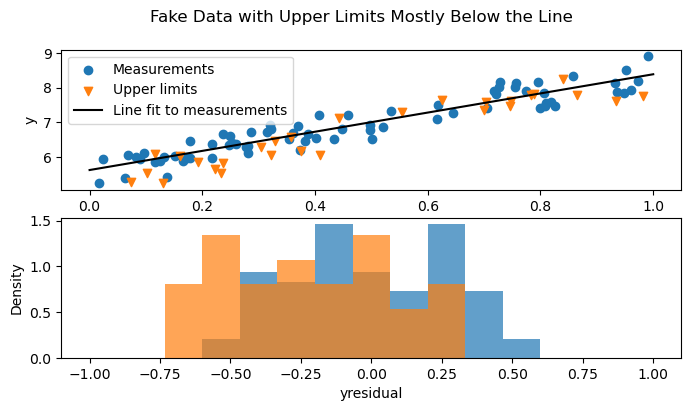

In [6]:
#Plot both a scatter plot and histograms of this.
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=False,figsize=(8,4))
fig.suptitle('Fake Data with Upper Limits Mostly Below the Line')

ax1.scatter(x[~lims],y[~lims],label='Measurements') #Scatter plot of the actually measurement (NOT lims is ~lims)
ax1.scatter(x[lims], y[lims], marker='v',label='Upper limits') #Scatter plot of the upper limits (lims=TRUE entries)
ax1.plot(xplot,yplot,'k',label='Line fit to measurements')
ax1.legend()
ax1.set_ylabel('y')
ax1.set_xlabel('x')

#Two histograms showing detections and upper limits.
#Note that the bins are lined up using range and bins
#Density=True makes it a probability density (bin height is the fraction of the subsample in that bin)
#Alpha=0.7 makes it slightly see through.
ax2.hist(yres[~lims],range=[-1,1],bins=15,density=True,alpha=0.7)
ax2.hist(yres[lims],range=[-1,1],bins=15,density=True,alpha=0.7)
ax2.set_ylabel('Density')
ax2.set_xlabel('yresidual')



# Comparing Distributions with Upper Limits

## Cummulative Distribution Function - Kaplan Meier Estimator

When you have upper limits, histograms aren't really a correct representation of the data, since the values represented by the upper limit might actually be samples from any histogram bin containing entries equal to or of lower value than the upper limit.

A cumulative distribution function (CDF) is a better choice since that counts the fraction of the sample below a given measurement, so once you reach the value of the upper limit you know the data point in question is at or below it.

We run the Kaplan Meier Estimator for the CDF. This outputs a python dictionary containing:
           
*   midpoint: where the CDF hits 0.5 (aka the median)
*   l68: lower 1-sigma confidence interval on midpoint
*   h68: upper 1-sigma confidence interval on midpoint
*   km: another dictionary with the results:
      * x: the y variable value
      * surv: the resulting cd

  

In [7]:
cdf = kaplan_meier(yres,lims)

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: package ‘stats’ is a base package, and should not be updated 
  


    lim     gs
1     0 -0.277
2     1 -0.492
3     0 -0.092
4     0  0.039
5     0 -0.226
6     0  0.172
7     0 -0.014
8     0  0.280
9     1 -0.038
10    0 -0.431
11    1  0.305
12    1 -0.548
13    1 -0.727
14    0 -0.579
15    1 -0.088
16    0 -0.193
17    0  0.345
18    1 -0.464
19    0  0.132
20    0 -0.168
21    1  0.262
22    0 -0.231
23    0  0.081
24    0  0.188
25    0  0.140
26    0  0.406
27    1  0.135
28    0  0.322
29    0 -0.344
30    1 -0.580
31    0 -0.001
32    1 -0.362
33    0  0.451
34    0 -0.093
35    1 -0.071
36    1 -0.696
37    0 -0.059
38    1 -0.299
39    1  0.011
40    0 -0.226
41    1 -0.585
42    0  0.382
43    0 -0.455
44    0  0.153
45    0 -0.340
46    1 -0.027
47    0  0.292
48    0  0.256
49    0  0.001
50    0 -0.155
51    1 -0.219
52    0 -0.294
53    0  0.237
54    0 -0.100
55    0 -0.076
56    0 -0.183
57    1  0.000
58    1 -0.202
59    1  0.145
60    0  0.329
61    0 -0.133
62    0 -0.421
63    0  0.224
64    0 -0.485
65    1 -0.717
66    1 -0

R callback write-console: 
Attaching package: ‘NADA’

  
R callback write-console: The following object is masked from ‘package:stats’:

    cor

  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


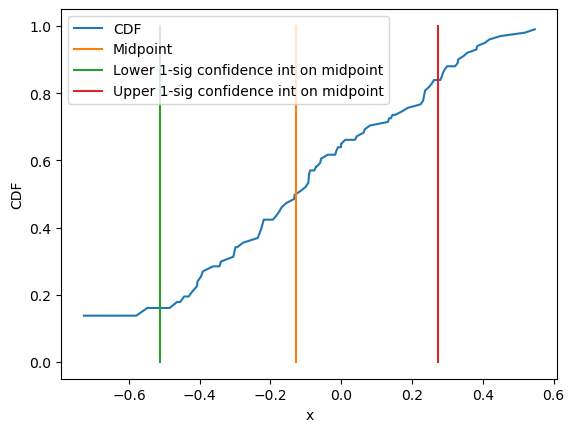

In [16]:
plt.plot(cdf['km']['x'],cdf['km']['surv'],label='CDF')
plt.plot([cdf['midpoint'],cdf['midpoint']],[0,1],label='Midpoint')
l68 = np.array(cdf['midpoint'])-np.array(cdf['l68'])
plt.plot([l68,l68],[0,1],label='Lower 1-sig confidence int on midpoint')
h68=np.array(cdf['midpoint'])+np.array(cdf['h68'])
plt.plot([h68,h68],[0,1],label='Upper 1-sig confidence int on midpoint')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()


Median:  -0.1316450879384492
Median confidence interval:  -0.0565209508645399 to  -0.22643248357370727
Error on median pos:  -0.09478739563525806 neg:  -0.0751241370739093
Make sure to round to a reasonable number of significant figures


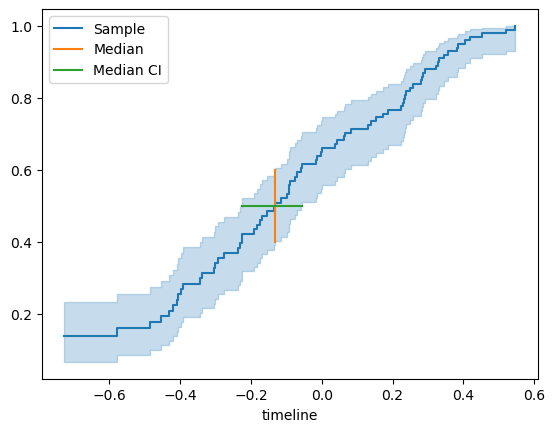

In [37]:
#This will do the same thing using the Kaplan Meier code in lifelines, looks the same but has nice error ranges. I'd do this one.
kmf = KaplanMeierFitter()
kmf.fit_left_censoring(yres,~lims) #Lims=True for upper limits, but this function assumes you pass a list of True for detections.
kmf.plot_cumulative_density(label='Sample') #will plot the CDF

median = kmf.median_survival_time_
median_confidence_interval = median_survival_times(kmf.confidence_interval_)
L95=np.array(median_confidence_interval)[0][0] #Why - I don't know but this works! 
H95=np.array(median_confidence_interval)[0][1] #Why - I don't know but this works! 

plt.plot([median,median],[0.4,0.6],label='Median')
plt.plot([L95,H95],[0.5,0.5],label='Median CI')
#plt.plot([L95,L95],[0.4,0.6],label='L95th')
#plt.plot([H95,H95],[0.4,0.6],label='H95th')
plt.legend()

print('Median: ', median)
print('Median confidence interval: ',L95, 'to ', H95)
print('Error on median pos: ', H95-median, 'neg: ', median-L95)
print('Make sure to round to a reasonable number of significant figures')

## Comparing Distributions

If you have all measurements, you can do a


*   KS2Sample Test (scipy.ks2samp)
*   Anderson-Darling Test (scipy.anderson_ksamp)

These return a probability of the null hypothesis (pvalue), that the samples are drawn from the SAME distribution - so low pvalues mean they are likely different ($p<0.05$ is a common threshold)

Statisticians prefer Anderson-Darling because it is more sensititve to the extremes of the distribution.

This doesn't work for datasets with upperlimits (left or right censorered), but we can compare the CDFs, which can return similar statistics.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.62 0.01      7.44

0.005761622564713603
7.623385499044037


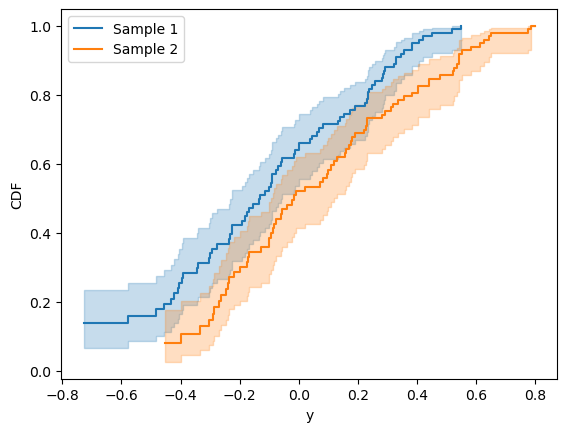

In [38]:
#let's make a second sample with a different distribution and compare them
y2 = 5.1 + (3.1 * x) + np.random.uniform(size=100) #Just a line with error of size 0-1
yres2= y2-p(x)

kmf.fit_left_censoring(yres,~lims) #Lims=True for upper limits, but this function assumes you pass a list of True for detections.
kmf.plot_cumulative_density(label='Sample 1') #will plot the CDF

kmf.fit_left_censoring(yres2, ~lims)
kmf.plot_cumulative_density(label='Sample 2') #will plot the CDF

plt.xlabel('y')
plt.ylabel('CDF')

results = logrank_test(-yres, -yres2, event_observed_A=~lims, event_observed_B=~lims)
results.print_summary()
print(results.p_value)

print(results.test_statistic)

## Fitting a Line with Upper Limits

Obviously our random data has some correlations. So we can try to deal with that too.

### Akritas-Theil-Sen estimator

The Akritas-Theil-Sen (ATS) estimator (Akritas et al. 1995) is a method which can be used to fit a line to data in the presence of upper limits.

More should be written here about how this works, but first think about the problem - usually line fits is done by minimising some kind of sum of the distance from the points to the best fit line. With upper limits you don't know the actual distance, only the minimum/maximum it could be (for upper limits below/above the line of best fit). So this technique accounts for that by minimising a median value of residuals using other techniques for calculating medians in the presence of upper limits (I think that's what I understand anyway).

In [39]:
#This command (a function from survival.py) runs cenken from R (Akritas-Theil-Sen estimator) to determine correlation
# strength and line fit parameters in the presence of upper limits

out = ats_fit(x,y,lims,fmt='(I4, 2F10.3)')
out

#The return will be the slope and intercept of the best fit line,
#It also returns tau (Kendall's tau; or Kendall's rank correlation coefficient)
#and p-value (probability of no correlation) for the regression.
#Small p-values and tau far from 0 suggest good correlation.
#And it will return estimates of the sigma (variance) both above and below the line


slope 
[1] 2.758412

intercept 
[1] 5.498795

tau 
[1] 0.5454545

p 
[1] 6.661338e-16



R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


{'slope': array([2.75841174]),
 'intercept': array([5.50152318]),
 'tau': array([0.54545455]),
 'p': array([6.66133815e-16]),
 'sigma_up': array([0.38131281]),
 'sigma_down': array([0.40067785])}

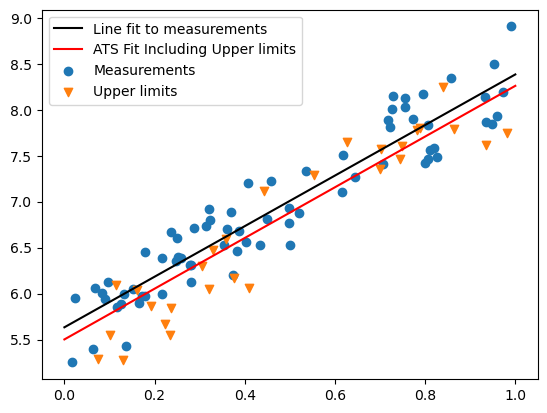

In [40]:
#Now lets plot the line over our fake data

xplot2=np.arange(0,1.1,0.1) #Makes array from 0-1, step size 0.1
yplot2=out['slope'][0]*xplot2+out['intercept'][0] #Makes line
plt.plot(xplot,yplot,'k',label='Line fit to measurements')
plt.plot(xplot2,yplot2,'r',label='ATS Fit Including Upper limits')
plt.plot

#plt.xlim(0,1)
plt.scatter(x[~lims],y[~lims],label='Measurements') #Scatter plot of the actually measurement (NOT lims is ~lims)
plt.scatter(x[lims], y[lims], marker='v',label='Upper limits') #Scatter plot of the upper limits (lims=TRUE entries)
plt.legend()